# Выбросы, Пустые значения, Категориальные признаки

# Домашнее задание

## Дано:
* Датафрейм с 3 признаками : (status, income, age)
* status: (Student, Pensioneer, Working, Businessman)
* income - доход в месяц
* age - возраст

## Нужно сделать:
* Провести разведочный анализ: describe(), кол-во пропусков, выбросов, построить boxplot и тп.
* Заполнить(удалить) пропуски, заменить(удалить) выбросы, кратко аргументировать замены. 
* Получить датафрейм с качественными данными

# Знакомство с данными

In [180]:
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [181]:
df = pd.read_csv('HomeWork.csv', index_col=0)

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   status  490 non-null    object 
 1   income  430 non-null    float64
 2   age     441 non-null    float64
 3   date    500 non-null    object 
dtypes: float64(2), object(2)
memory usage: 19.5+ KB


In [183]:
# взглянем на 5 примеров объктов из данных
df.sample(5)

,status,income,age,date
485,Student,-2112.0,20.0,2022-01-01
238,Working,131000.0,54.0,2022-01-29
15,Working,-2658.0,42.0,2022-01-31
437,Student,NaN,19.0,2022-01-18
101,Working,218000.0,52.0,2022-01-17


In [184]:
df.describe()

,income,age
count,430.000000,441.000000
mean,152020.623256,46.362812
std,242647.036978,25.036517
min,-13745.000000,0.000000
25%,2000.000000,23.000000
50%,21000.000000,44.000000
75%,217000.000000,68.000000
max,992000.000000,99.000000


Можем заметить следующее:
- в income присутствуют отрицательные значения
- max = 992 000, при условии, что 75% - это 217 000, что **может** говорить о выбросах
- присутсвуют пользователи с "нулевым" возрастом

# Посмотрим на пропуски

In [185]:
def get_nan_info(df):
    """
    Статистика по наличию пропусков в признаках.
    df - датасет с признаками
    """
    df = df.copy()  
    nans_df = pd.DataFrame(df.isnull().sum().rename('n_nans'))
    
    N = df.shape[0]
    nans_df['ratio_nans'] = nans_df['n_nans']/N
    nans_df['ratio_nans'] = nans_df['ratio_nans'].round(2)
    
    nans_df = nans_df[nans_df['n_nans']>0]
    nans_df = nans_df.sort_values(by='n_nans', ascending=False)
        
    return nans_df 

In [186]:
nan = get_nan_info(df)
nan

,n_nans,ratio_nans
income,70,0.14
age,59,0.12
status,10,0.02


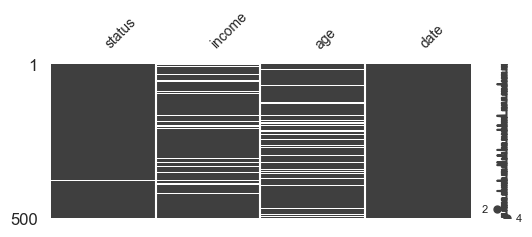

In [187]:
msno.matrix(df, figsize=(6,2), fontsize=10);

Пропуски часто не совпадают у возраста и дохода, что может помочь при заполнении NaN.

# Посмтрим на фичи

In [188]:
# Разделение признаков на численные и категориальные
numeric_features = df.select_dtypes(include=[int, float])
categorical_features = df.select_dtypes(include=[object])

## Числовые

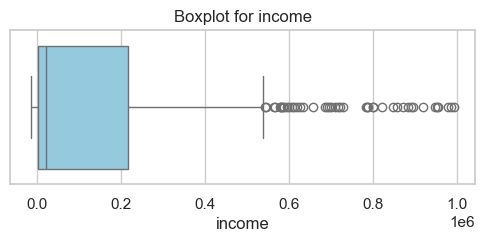

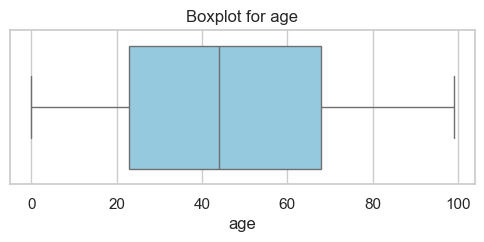

In [189]:
# Построение boxplot для численных признаков
for col in numeric_features.columns:
    plt.figure(figsize=(6, 2))
    sns.boxplot(data=numeric_features, x=col, color='skyblue')
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    plt.show()

Заметим большое кол-во выбросов на общем графике income. Построим ящики по подгруппам в зависимости от статуса.

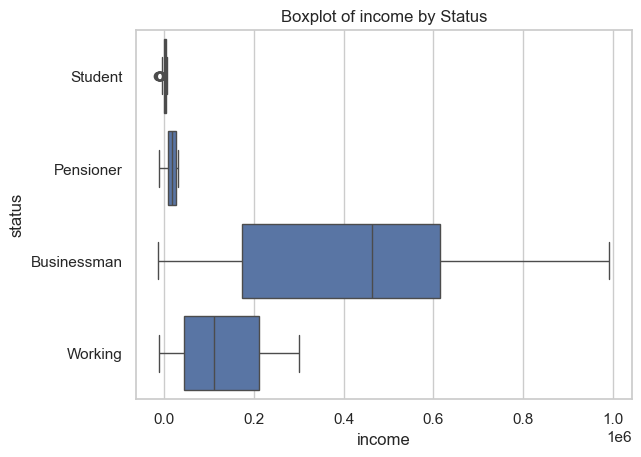

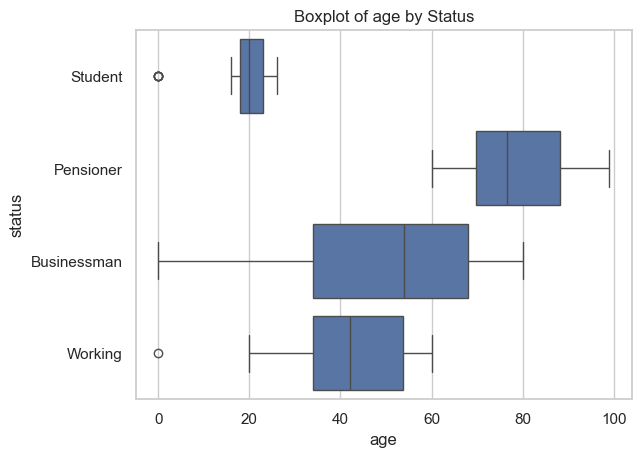

In [190]:
for col in numeric_features.columns:
    # plt.figure(figsize=(6, 2))
    sns.boxplot(y=df.status, x=df[col]) 
    plt.title(f'Boxplot of {col} by Status') 
    plt.xlabel(col)
    plt.show()


Заметим, что для income в подгруппах практически отсутствуют выбросы, а основу выбросов на общем графике сотсавил доход подгруппы Businessman, которая вполне может иметь высокие значения.

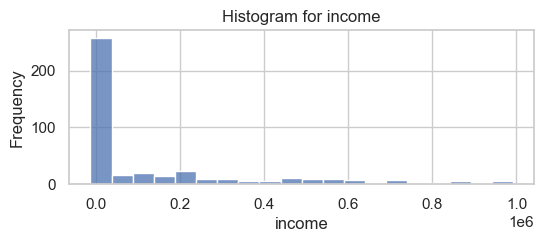

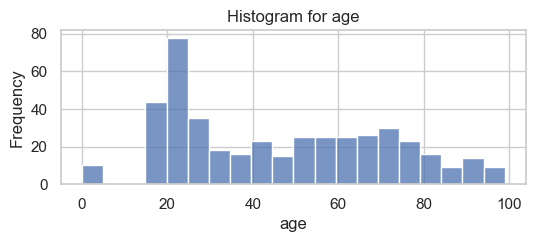

In [191]:
# Построение гистограмм для численных признаков
for col in numeric_features.columns:
    plt.figure(figsize=(6, 2))
    sns.histplot(data=numeric_features, x=col, bins=20)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

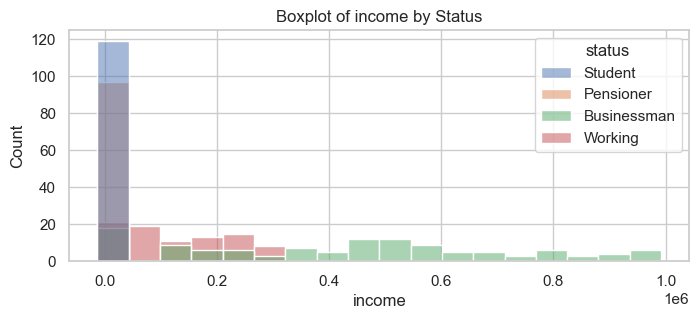

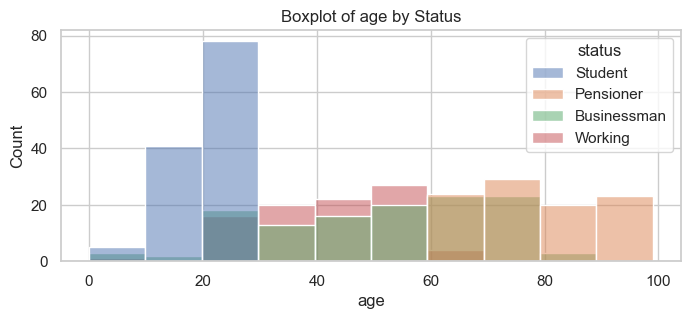

In [192]:
for col in numeric_features.columns:
    plt.figure(figsize=(8, 3))
    sns.histplot(x=df[col], hue=df.status) 
    plt.title(f'Boxplot of {col} by Status') 
    plt.xlabel(col)
    plt.show()

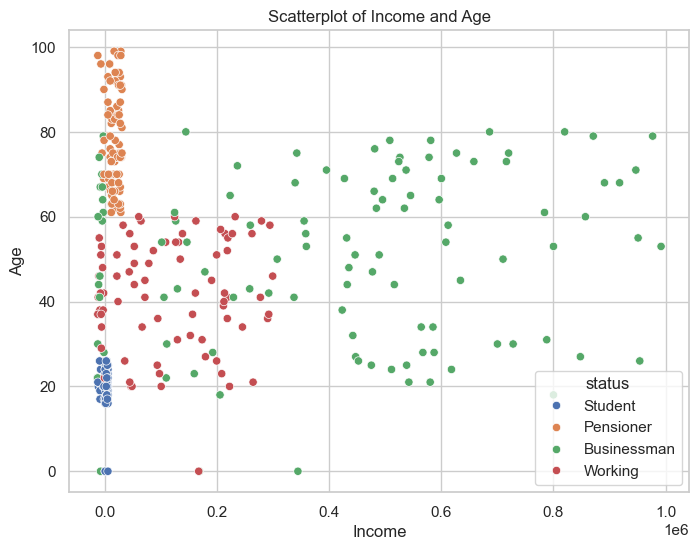

In [193]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='income', y='age', hue='status');
plt.xlabel('Income')
plt.ylabel('Age')
plt.title('Scatterplot of Income and Age')
plt.show()

Дополнительного деления на подгруппы возраста в заполнении пропусков не требуется, потому как нет явной корреляции между доходом и возрастом

Взглянем на распределение отрицательных значений income

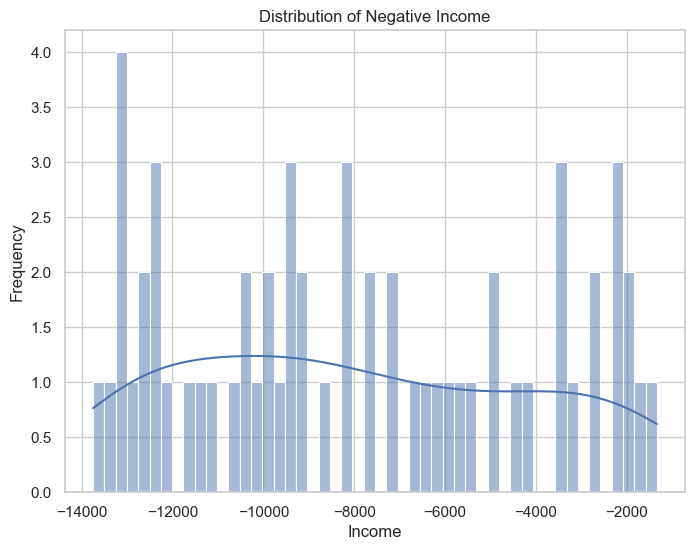

In [194]:
# Фильтрация отрицательных значений признака income
negative_income = df[df['income'] < 0]['income']

# Создание гистограммы с помощью Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(negative_income, bins=50, kde=True)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Distribution of Negative Income')
plt.show()

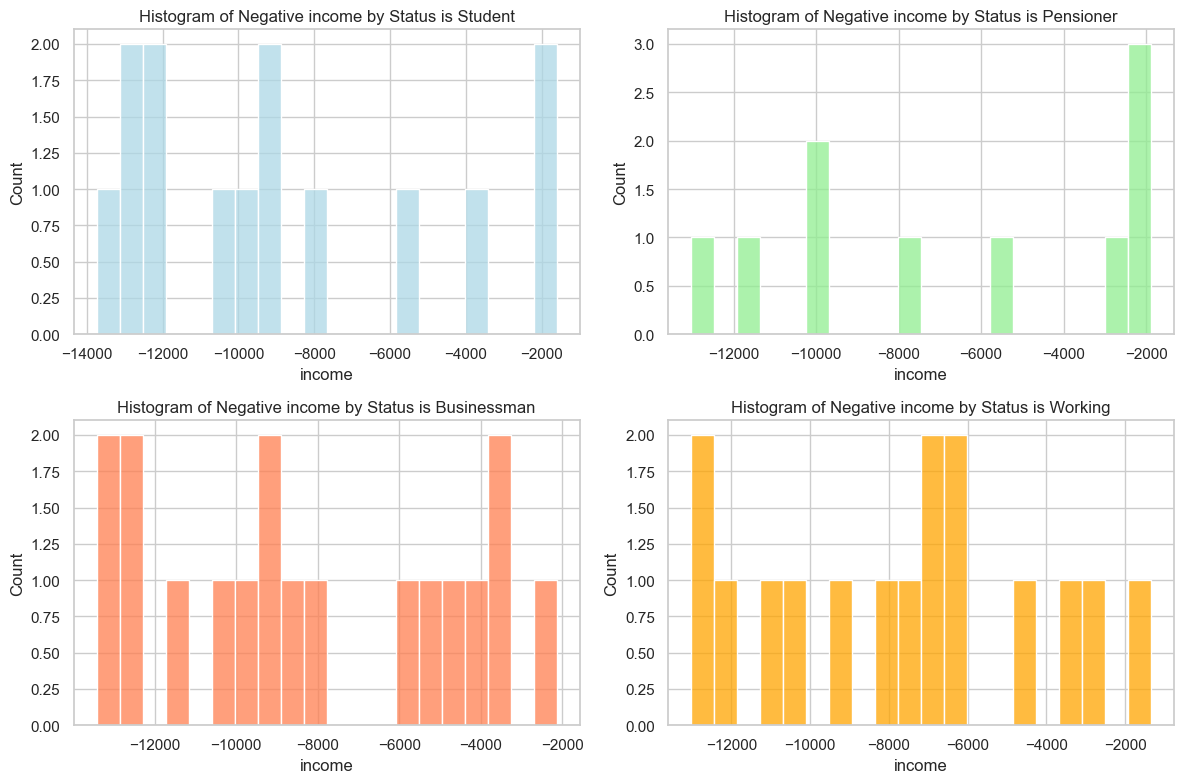

In [195]:
unique_statuses = list(df['status'].unique()[:-1])

# Создание матрицы графиков
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Словарь цветов для каждого статуса
colors = ['lightblue', 'lightgreen', 'coral', 'orange']

# Итерация по строкам и столбцам матрицы графиков
for i in range(2):
    for j in range(2):
        status = unique_statuses[i*2 + j]  # Выбор статуса для текущего графика
        ax = axes[i, j]  # Получение текущего подграфика

        # Отрисовка гистограммы с нужным цветом
        sns.histplot(data=df[(df.income < 0) & (df.status == status)], x='income', bins=20, color=colors[i*2 + j], ax=ax)

        # Настройка заголовка и меток осей для текущего графика
        ax.set_title(f'Histogram of Negative income by Status is {status}')
        ax.set_xlabel('income')

# Расположение графиков в матрице
plt.tight_layout()
plt.show()

## Категориальные

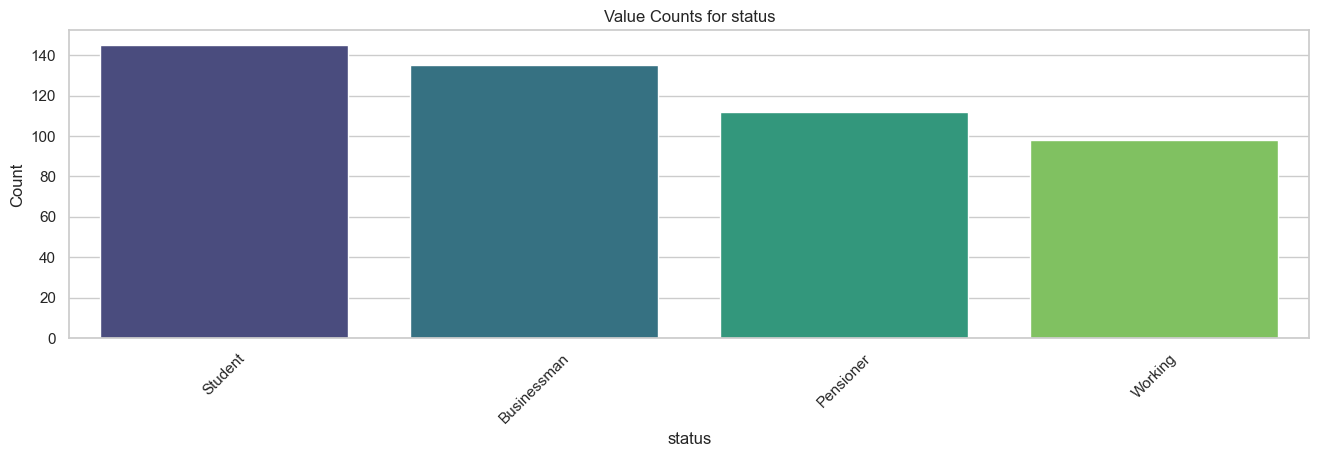

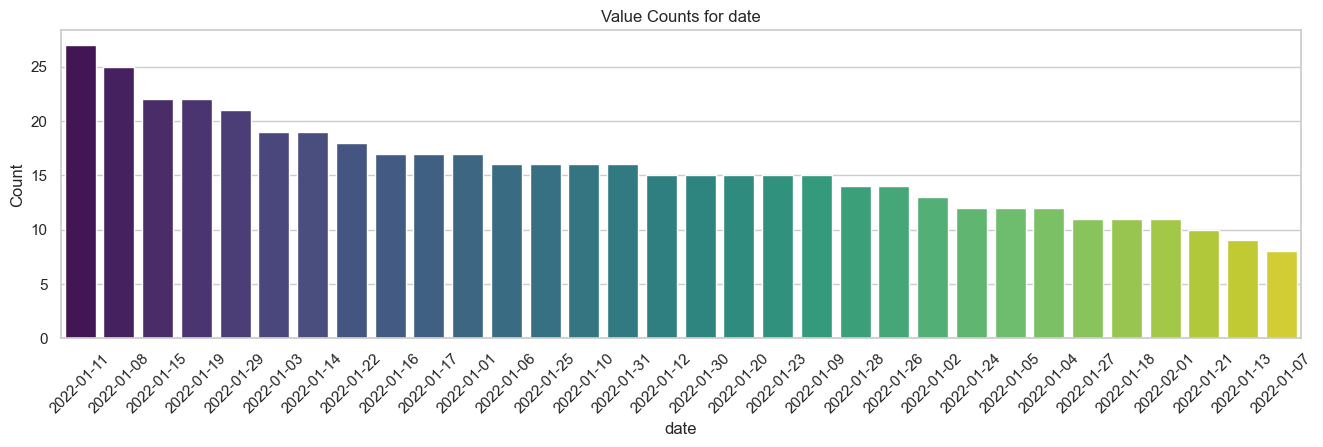

In [196]:
# Подсчет количества значений и построение bar диаграмм для категориальных признаков
for col in categorical_features.columns:
    plt.figure(figsize=(16, 4))
    value_counts = categorical_features[col].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts, palette="viridis")
    plt.title(f'Value Counts for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

Представлены данные с 1 января по 1 февраля включительно.

##

Проверим несут ли отрицательные занчения доходов и нули в возрасте систематический характер. Возможно в какой-то день произошел сбой или были какие-нибудь тесты системы???

In [197]:
df['date'] = pd.to_datetime(df['date'])

df['day'] = df.date.dt.day.values
df['weekday'] = df.date.dt.weekday.values
df['is_weekend'] = df.weekday.map(lambda x: 1 if x in (5, 6) else 0)

Сгруппируем по дню недели данные с отрицательным доходом и посчитаем количесвто таких записей в каждой подгруппе

In [198]:
df[df.income < 0].groupby(by='weekday').agg({'age': 'count'}).sort_values(by='weekday', ascending=True).rename(columns={'age' : 'count'})

,count
weekday,
0,9
1,7
2,7
3,3
4,6
5,10
6,12


In [199]:
df[df.age <= 0].groupby(by='weekday').agg({'age': 'count'}).sort_values(by='weekday', ascending=True).rename(columns={'age' : 'count'})

,count
weekday,
0,3
1,1
2,3
6,3


In [200]:
df[(df.income < 0) | (df.age <= 0)].groupby(by='date').agg({'age': 'count'}).sort_values(by='age', ascending=False).rename(columns={'age' : 'count'})

,count
date,
2022-01-16,6
2022-01-31,4
2022-01-29,4
2022-01-23,4
2022-01-19,4
2022-01-01,3
2022-01-15,3
2022-01-03,3
2022-01-26,3


Большинство аномальных занчений наблюдается в Вс и Пн, но назвать это явной закономерностью тяжело. Также не отмечено определенных дней, в котрые произошло значительно больше ошибок, чем в остальные.

В данном случае невозможно точно определить причины отрицательных значений в доходе. Можно лишь догадываться, было ли это ошибкой и, например, следует брать абсолютное значение или же данные несут какую-либо полезную информацию (например, харктеризуют убытки).

# Поработаем с пропусками

Чтобы не выдумавать, заменим отрицательные значения на медиану подгруппы по статусу.

## Для начала избавимся от NaN в самом status.

In [201]:
df[(df.status.isna())]

,status,income,age,date,day,weekday,is_weekend
35,NaN,286000.0,53.0,2022-01-30,30,6,1
65,NaN,NaN,76.0,2022-01-10,10,0,0
83,NaN,262000.0,35.0,2022-01-19,19,2,0
169,NaN,9000.0,85.0,2022-01-19,19,2,0
197,NaN,169000.0,59.0,2022-01-17,17,0,0
359,NaN,30000.0,0.0,2022-01-05,5,2,0
376,NaN,-7248.0,81.0,2022-01-12,12,2,0
378,NaN,NaN,16.0,2022-01-22,22,5,1
382,NaN,79000.0,24.0,2022-01-22,22,5,1
468,NaN,691000.0,54.0,2022-01-10,10,0,0


In [202]:
# Получение индексов объектов, где статус NaN
nan_status_indices = df[df.status.isna()].index.tolist()
nan_status_indices


[35, 65, 83, 169, 197, 359, 376, 378, 382, 468]

In [203]:
# Фильтрация данных, где возраст больше 0 и доход больше или равен 0
filtered_age_data = df[(df['age'] > 0)]
filtered_income_data = df[(df['income'] >= 0)]

# Группировка отфильтрованных данных по статусу и агрегация минимальных и максимальных значений возраста и дохода
status_summary_age = filtered_age_data.groupby('status').agg(
    min_age=('age', 'min'),
    max_age=('age', 'max'),
)
status_summary_income = filtered_income_data.groupby('status').agg(
    min_income=('income', 'min'),
    max_income=('income', 'max')
)

# Объединение наборов данных по статусу
merged_summary = status_summary_age.merge(status_summary_income, on='status')
merged_summary


,min_age,max_age,min_income,max_income
status,,,,
Businessman,18.0,80.0,101000.0,992000.0
Pensioner,60.0,99.0,5000.0,30000.0
Student,16.0,26.0,0.0,5000.0
Working,20.0,60.0,21000.0,299000.0


На основе merged_summary обозначим условия принадлежности к определенной подгруппе:

Pensioner - возраст >= 60\
Student - возраст менее 26 + доход <= 5000 \
Working - доход менее 300к и возраст менее 60\
Businessman - доход >= 300к и не подошел под  остальные категории

In [204]:
df.loc[(df.status.isna()) & (df.age > 60), 'status'] = 'Pensioner'
df.loc[(df.status.isna()) & (df.age < 60) & (df.income < 300000), 'status'] = 'Working'
df.loc[(df.status.isna()) & (df.age < 26) & (df.income <= 5000) , 'status'] = 'Student'
df.loc[(df.status.isna()) & (df.income >= 300000), 'status'] = 'Businessman'

In [205]:
df.loc[nan_status_indices]

,status,income,age,date,day,weekday,is_weekend
35,Working,286000.0,53.0,2022-01-30,30,6,1
65,Pensioner,NaN,76.0,2022-01-10,10,0,0
83,Working,262000.0,35.0,2022-01-19,19,2,0
169,Pensioner,9000.0,85.0,2022-01-19,19,2,0
197,Working,169000.0,59.0,2022-01-17,17,0,0
359,Working,30000.0,0.0,2022-01-05,5,2,0
376,Pensioner,-7248.0,81.0,2022-01-12,12,2,0
378,NaN,NaN,16.0,2022-01-22,22,5,1
382,Working,79000.0,24.0,2022-01-22,22,5,1
468,Businessman,691000.0,54.0,2022-01-10,10,0,0


Остался 1 объект, у которго вместе со статусом не было информации о доходе. Т.к. возраст = 16, делаем вывод, что это студент.

In [206]:
df.loc[378, 'status'] = 'Student'

Убедимся, что данные заполнились корректно.

In [207]:
df.loc[nan_status_indices]

,status,income,age,date,day,weekday,is_weekend
35,Working,286000.0,53.0,2022-01-30,30,6,1
65,Pensioner,NaN,76.0,2022-01-10,10,0,0
83,Working,262000.0,35.0,2022-01-19,19,2,0
169,Pensioner,9000.0,85.0,2022-01-19,19,2,0
197,Working,169000.0,59.0,2022-01-17,17,0,0
359,Working,30000.0,0.0,2022-01-05,5,2,0
376,Pensioner,-7248.0,81.0,2022-01-12,12,2,0
378,Student,NaN,16.0,2022-01-22,22,5,1
382,Working,79000.0,24.0,2022-01-22,22,5,1
468,Businessman,691000.0,54.0,2022-01-10,10,0,0


## Остальные признаки

Теперь на основе подгрупп по статусу заполним 0 и пропуски  в остальных признаках медианным значением подгруппы.

In [208]:
print(f'Количество NaN в доходах: {df.income.isna().sum()}')
print(f'Количество NaN в возрасте: {df.age.isna().sum()}')

Количество NaN в доходах: 70
Количество NaN в возрасте: 59


In [209]:
print(f'Количество людей с отрицательным доходом: {df.income[df.income < 0].count()}')
print(f'Количество людей с нулевым возрастом: {df.age[df.age == 0].count()}')

Количество людей с отрицательным доходом: 59
Количество людей с нулевым возрастом: 10


In [210]:
# Замена отрицательных значений в столбце 'income' на NaN
df.loc[df['income'] < 0, 'income'] = np.nan

# Замена значений равных 0 в столбце 'age' на NaN
df.loc[df['age'] == 0, 'age'] = np.nan

In [211]:
print(f'Количество NaN в доходах: {df.income.isna().sum()}')
print(f'Количество NaN в возрасте: {df.age.isna().sum()}')

Количество NaN в доходах: 129
Количество NaN в возрасте: 69


In [212]:
# Расчет медианы дохода для каждой категории статуса
median_income_by_status = df.groupby('status')['income'].median()
# Расчет медианы возраста для каждой категории статуса
median_age_by_status = df.groupby('status')['age'].median()

merged_nan = pd.merge(median_income_by_status, median_age_by_status, on='status').reset_index()
merged_nan


,status,income,age
0,Businessman,512000.0,54.0
1,Pensioner,18000.0,77.0
2,Student,2000.0,20.5
3,Working,158500.0,42.0


In [213]:
# Заполнение пропущенных значений в столбцах 'income' и 'age' медианным значением подгруппы по статусу
df['income'] = df.groupby('status')['income'].transform(lambda x: x.fillna(x.median()))
df['age'] = df.groupby('status')['age'].transform(lambda x: x.fillna(x.median()))

In [214]:
# Расчет медианы дохода для каждой категории статуса
median_income_by_status_2 = df.groupby('status')['income'].median()
# Расчет медианы возраста для каждой категории статуса
median_age_by_status_2 = df.groupby('status')['age'].median()

merged_nan_2 = pd.merge(median_income_by_status_2, median_age_by_status_2, on='status').reset_index()
merged_nan_2

,status,income,age
0,Businessman,512000.0,54.0
1,Pensioner,18000.0,77.0
2,Student,2000.0,20.5
3,Working,158500.0,42.0


In [215]:
df.isna().sum()

status        0
income        0
age           0
date          0
day           0
weekday       0
is_weekend    0
dtype: int64

Медиана осталась прежней, от пропусков избавились.

# Итог

Конечные данные имеют следующий вид

In [216]:
# Разделение признаков на численные и категориальные
numeric_features = df.select_dtypes(include=[int, float])
categorical_features = df.select_dtypes(include=[object])

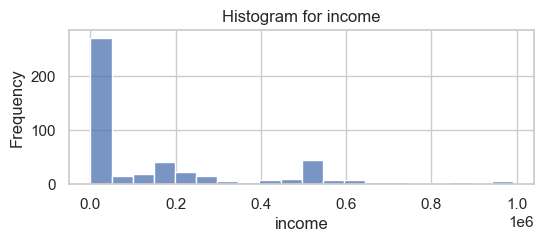

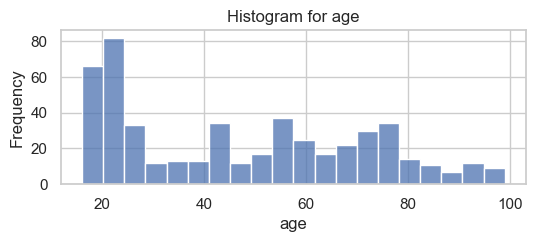

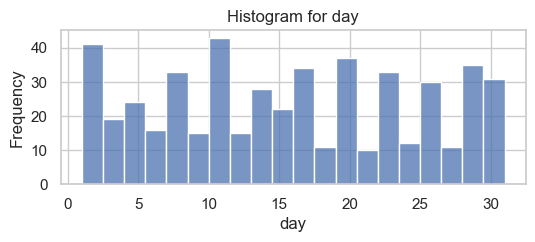

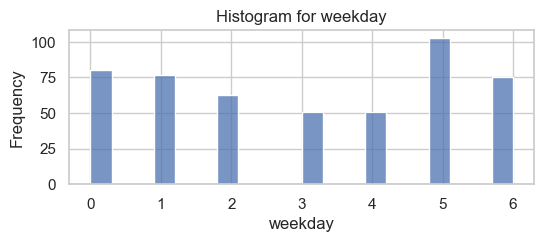

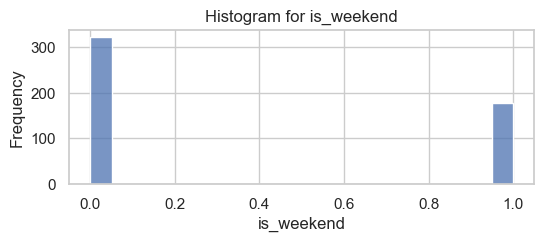

In [217]:
# Построение гистограмм для численных признаков
for col in numeric_features.columns:
    plt.figure(figsize=(6, 2))
    sns.histplot(data=numeric_features, x=col, bins=20)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [218]:
numeric_features = numeric_features.drop(columns=['day', 'weekday', 'is_weekend'])

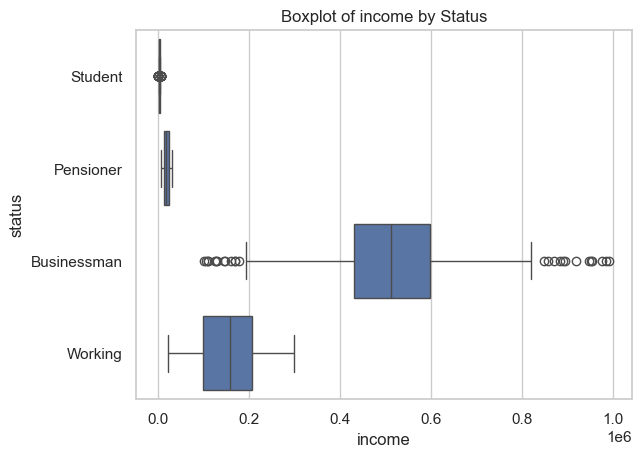

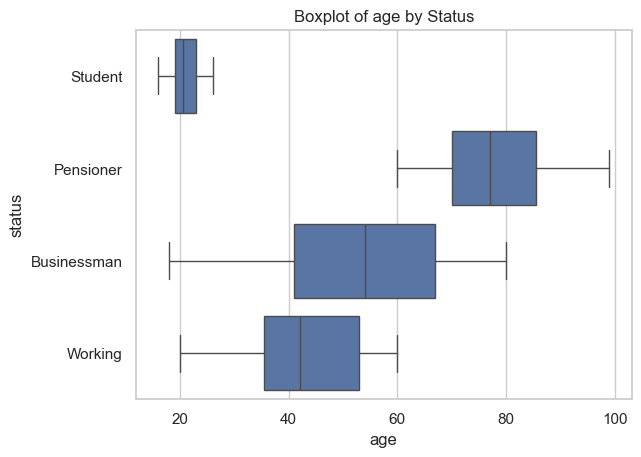

In [219]:
for col in numeric_features.columns:
    # plt.figure(figsize=(6, 2))
    sns.boxplot(y=df.status, x=df[col]) 
    plt.title(f'Boxplot of {col} by Status') 
    plt.xlabel(col)
    plt.show()


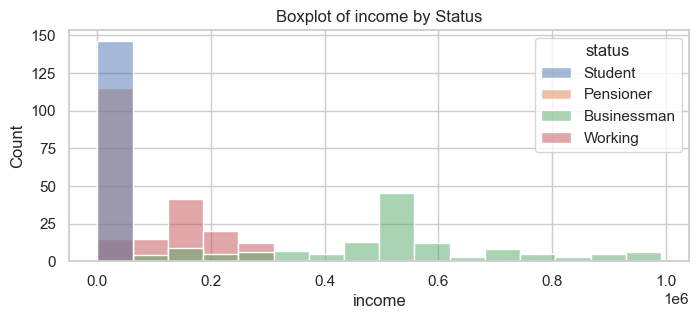

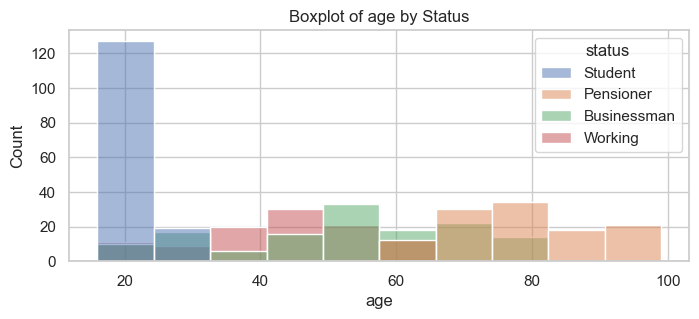

In [220]:
for col in numeric_features.columns:
    plt.figure(figsize=(8, 3))
    sns.histplot(x=df[col], hue=df.status) 
    plt.title(f'Boxplot of {col} by Status') 
    plt.xlabel(col)
    plt.show()

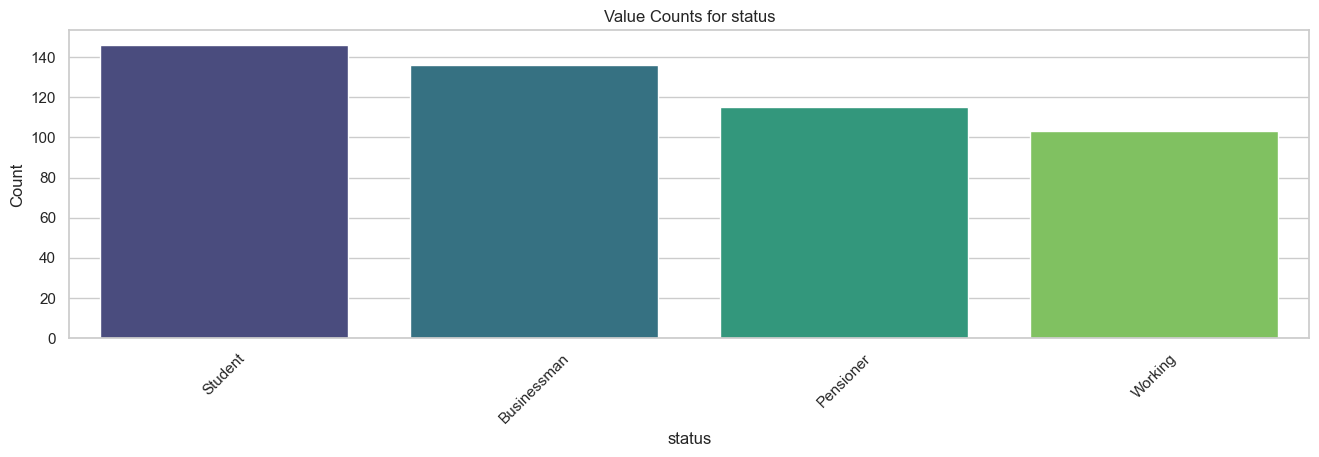

In [221]:
# Подсчет количества значений и построение bar диаграмм для категориальных признаков
for col in categorical_features.columns:
    plt.figure(figsize=(16, 4))
    value_counts = categorical_features[col].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts, palette="viridis")
    plt.title(f'Value Counts for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   status      500 non-null    object        
 1   income      500 non-null    float64       
 2   age         500 non-null    float64       
 3   date        500 non-null    datetime64[ns]
 4   day         500 non-null    int32         
 5   weekday     500 non-null    int32         
 6   is_weekend  500 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(1)
memory usage: 43.5+ KB
